In [1]:
import psycopg2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
DB_PARAMS = {
    "dbname": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"), 
    "host": "postgres",
    "port":  5432
}

In [32]:
try:
    conn = psycopg2.connect(**DB_PARAMS)
    cursor = conn.cursor()
    cursor.execute(""" 
        SELECT event_time, 
            CAST(REPLACE(REPLACE(price::text, '$', ''), ',', '') AS FLOAT) as price,
            category_code, brand, user_id
        FROM customers
        WHERE event_type = 'purchase'
        AND event_time BETWEEN '2022-10-01' AND '2023-02-28 23:59:59'
        ORDER BY event_time
    """)
    rows = cursor.fetchall()
    data = pd.DataFrame(rows, columns=['event_time', 'price', 'category_code', 'brand', 'user_id'])

    cursor.close()
    conn.close()
except Exception as e:
    print(f"❌ An error occurred: {e}")

In [33]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

In [34]:
if not pd.api.types.is_datetime64_any_dtype(data['event_time']):
    data['event_time'] = pd.to_datetime(data['event_time'])

In [35]:
data['date'] = data['event_time'].dt.date
data['month'] = data['event_time'].dt.to_period('M')
data['month_str'] = data['month'].dt.strftime('%b')

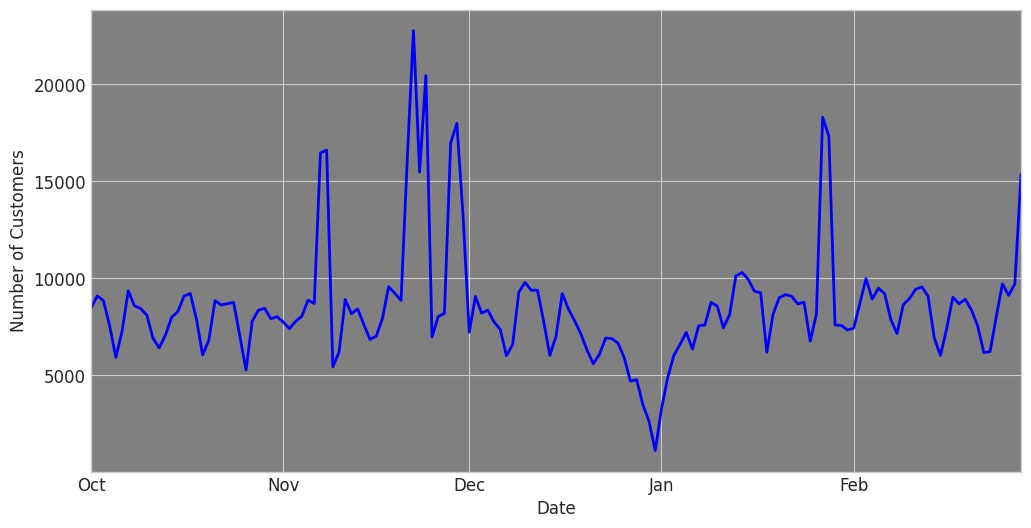

In [23]:
daily_customers = data.groupby('date').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
plt.plot(daily_customers['date'], daily_customers['count'], color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Customers')
locator = plt.matplotlib.dates.MonthLocator()
format = plt.matplotlib.dates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(format)
plt.xlim(daily_customers['date'].min(), daily_customers['date'].max())
plt.gca().set_facecolor('gray')
plt.show()
plt.close()

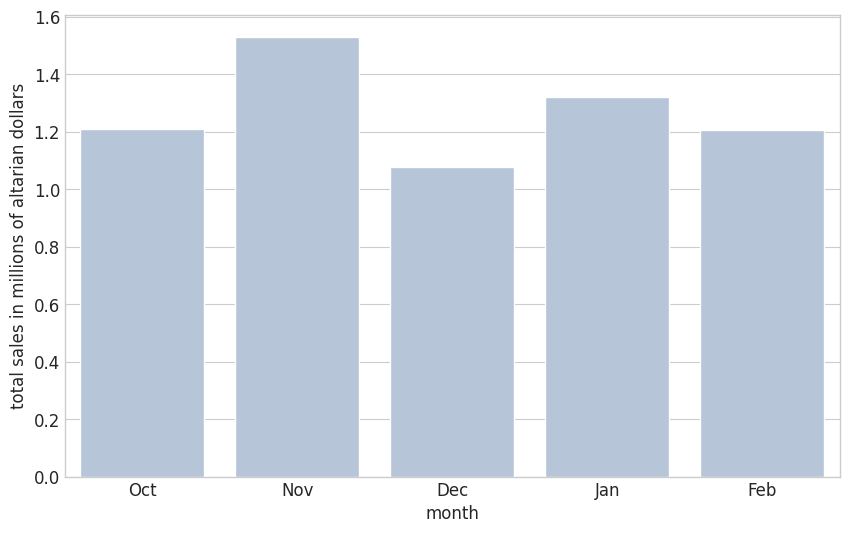

In [46]:
monthly_sales = data.groupby('month')['price'].sum().reset_index()
monthly_sales['sales_in_millions'] = monthly_sales['price'] / 1_000_000
monthly_sales['month_str'] = monthly_sales['month'].dt.strftime('%b')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='month_str', y='sales_in_millions', data=monthly_sales, color='#B0C4DE')
plt.xlabel('month')
plt.ylabel('total sales in millions of altarian dollars')
plt.show()
plt.close()


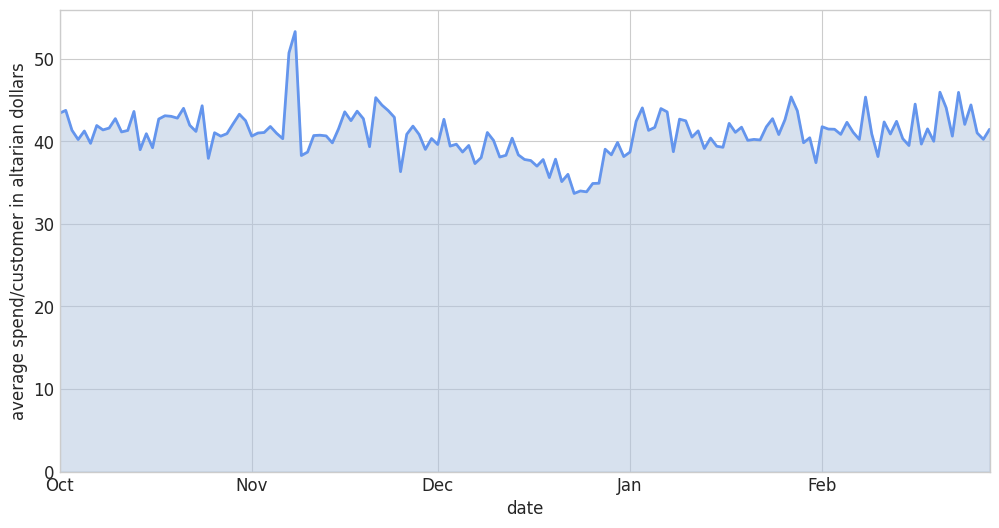

In [57]:
daily_data = data.groupby('date').agg(
    total_spend=('price', 'sum'),
    total_customers=('user_id', 'nunique') 
).reset_index()
daily_data['avg_spend_per_customer'] = daily_data['total_spend'] / daily_data['total_customers']
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['avg_spend_per_customer'], color='#6495ED', linewidth=2)
plt.fill_between(daily_data['date'], daily_data['avg_spend_per_customer'], color='#B0C4DE', alpha=0.5)
plt.xlabel('date')
plt.ylabel('average spend/customer in altarian dollars')
locator = plt.matplotlib.dates.MonthLocator()
format = plt.matplotlib.dates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(format)
plt.xlim(daily_data['date'].min(), daily_data['date'].max())
plt.ylim(bottom=0)
plt.show()
plt.close()